In [67]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context("talk")
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
import os, urllib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score
# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('dca')))
from dca.data_util import load_sabes_data
from dca import DynamicalComponentsAnalysis as DCA

# hyperparameters
N_e = 100
N_i = N_e
N = N_e + N_i
D = 20
sparsity = 0.25
U = 250
T = 100
max_iter = 10
N_weights = int (N * N * sparsity)

color_dict = {1:'tab:purple',2:'tab:pink',3:'tab:cyan',5:'yellowgreen', 10:'olive', 25:'tab:brown'}
colors_K = ['tab:orange','tab:blue','tab:green']

zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2)) for i in list(np.arange(-1,0.5,0.25))]

In [144]:
# simulation of interest
K = 3
simulation =  21 # 6
ei = 0
j = 0 # normal
data = np.load(f'models/N={N}_K={K}/EI={ei}_simulation_{simulation}_J_possibility_{j}.npz', allow_pickle=True)
J = data['J']
RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)

In [145]:
# eigenvalues = np.array([0.9, - 0.1 + 0.5j, - 0.1 - 0.5j])
trueA = data['trueA']
eigenvalues = np.linalg.eig(trueA)
print(trueA)



[[ 0.52689462  0.7477944  -0.11269588]
 [-0.26965427  0.12275707 -0.2820865 ]
 [ 0.26835369 -0.51124992  0.42964794]]


1.534857819217831Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


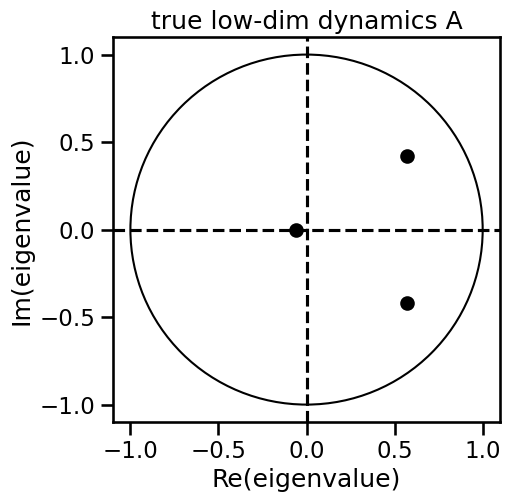

In [146]:
# eigenvalues = np.array([0.9, - 0.1 + 0.5j, - 0.1 - 0.5j])[:K]
# trueA = generate_dynamics_A(eigenvalues) # checked that A has above eigenvalues
# # trueA = all_param_true['trueA']

# trueA = np.ones((1,1)) * 0.9
# trueA = np.zeros((K,K))
# theta = np.pi/6
# trueA[0,0] = np.cos(theta)
# trueA[0,1] = - np.sin(theta)
# trueA[1,0] = np.sin(theta)
# trueA[1,1] = np.cos(theta)
# trueA = trueA * 0.95

eigenvalues = np.linalg.eigvals(trueA)
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('true low-dim dynamics A')
plot_eigenvalues(axes, eigenvalues)

print(np.trace(trueA.T @ trueA))
norm_A = np.trace(trueA.T @ trueA)



In [147]:
# creating eigenvalues sets for cluster fitting

# a = np.random.rand(1)[0]
# b = np.random.rand(1)[0]
# eigenvalues_odd = np.array([0.9, - 0.2 + 0.6j, - 0.2 - 0.6j, a + b*1j, a - b*1j])
# np.save('eigenvalues_K_odd_leq_5', eigenvalues_odd)

# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('true low-dim dynamics A')
# plot_eigenvalues(axes, eigenvalues_odd)

# eigenvalues_even = []
# for i in range(5):
#     x = 2 * (np.random.rand(1)[0] - 1/2)
#     y = 2 * (np.random.rand(1)[0] - 1/2)
#     eigenvalues_even.append(x + y * 1j)
#     eigenvalues_even.append(x - y * 1j)

# print(len(eigenvalues_even))
# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('true low-dim dynamics A')
# plot_eigenvalues(axes, np.array(eigenvalues_even)[:10])
# np.save('eigenvalues_K_even_leq_10', eigenvalues_even)


        

In [148]:
# # Weight initialization (step 0) - Hannequin et al 2012
# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# w0 = RNN.generate_stable_weights(R=0.85) 
# W0 = RNN.build_full_weight_matrix(w0)

# eig = np.linalg.eigvals(W0) 
# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('W initialization (step 0)')
# plot_eigenvalues(axes, eig)


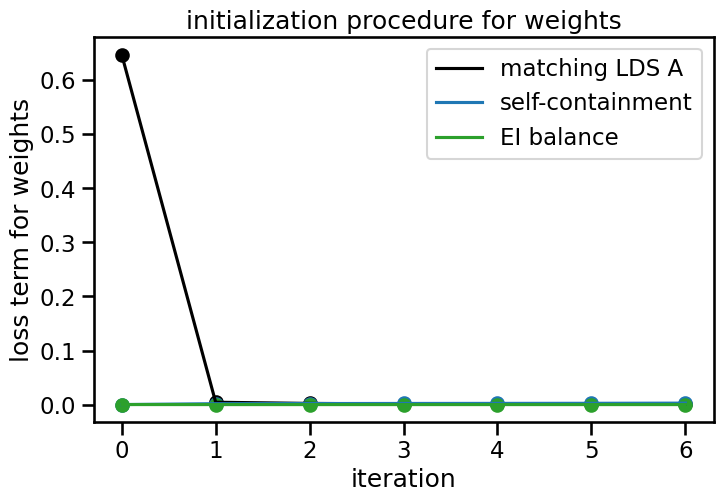

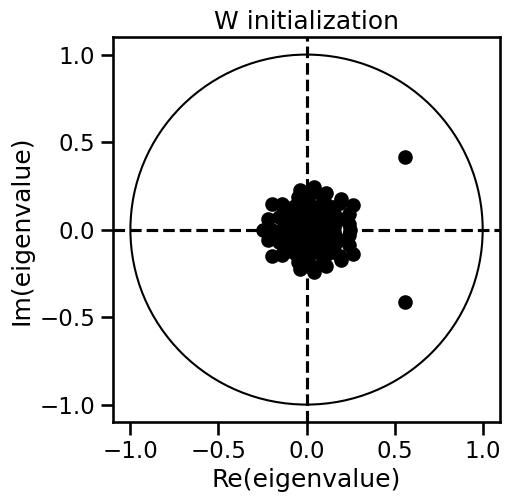

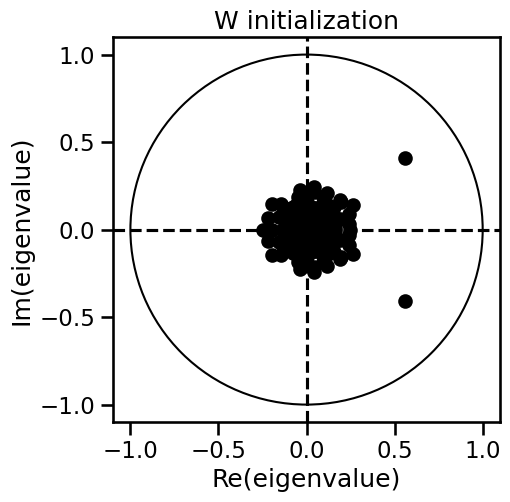

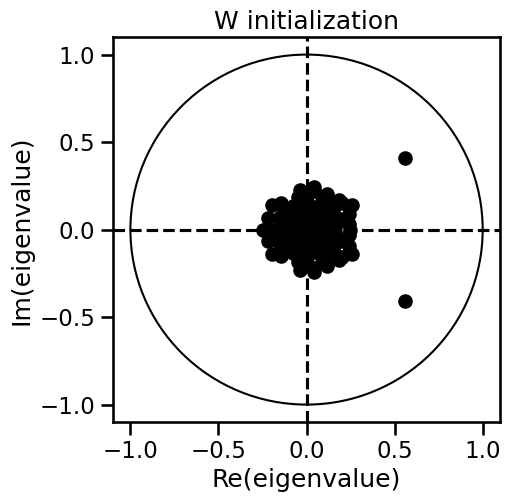

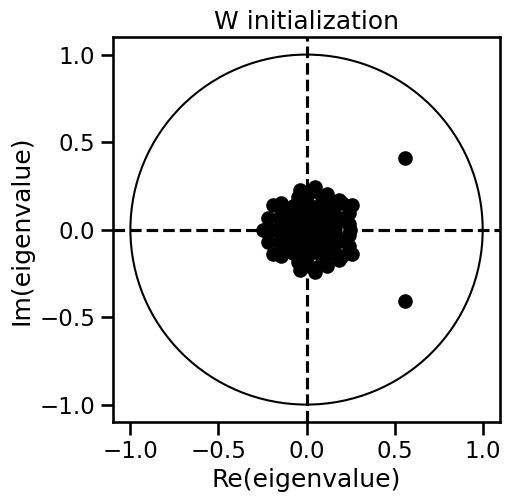

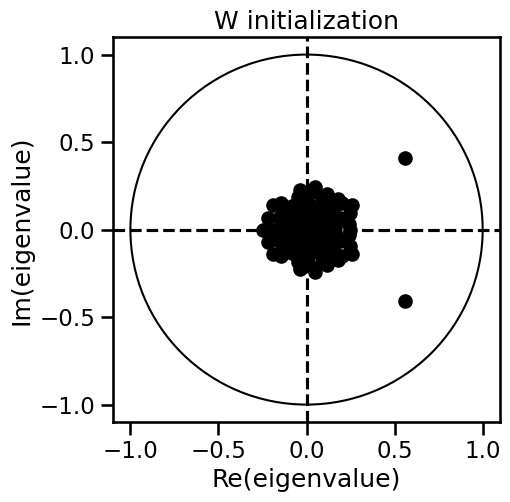

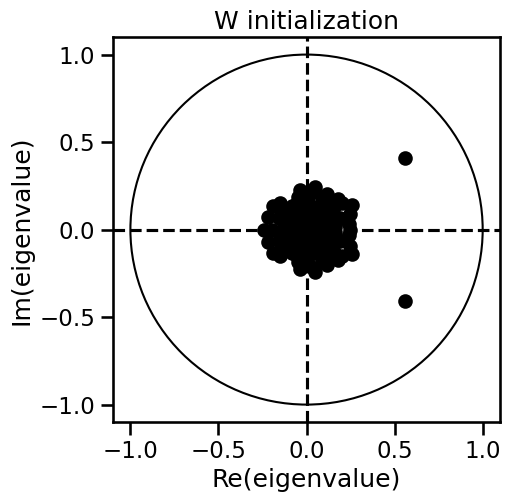

In [149]:
import math
# # Weight initialization - from true target LDS A
# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# # gamma = 0.001 works well for N<=150
# # gamma = 0.005 = 1/N for N=200 => instability
# # zeta_alpha_beta_gamma_list = [(10**i,1,1,1/N) for i in list(np.arange(-3,0.5,0.5))] #[10 ** i for i in list(np.arange(-3,1,0.5))]
# zeta_alpha_beta_gamma_list = [(10**i,1,1,0) for i in list(np.arange(-1,0.5,0.5))] #[10 ** i for i in list(np.arange(-3,1,0.5))]
# # try gamma scheme from high to low
# # try zeta scheme from N/norm_A
# initW0, initW, loss_W, w_all = RNN.generate_or_initialize_weights_from_dynamics_LDS(A_target=trueA, R=0.85, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
# init_w = RNN.get_nonzero_weight_vector(initW)
# initA = build_dynamics_matrix_A(initW, J)
# # np.save('loss_W', loss_W)
# # np.save('init_w', init_w)

initW0 = data['initW0']
initW = data['initW']
loss_W = data['loss_W']
w_all = data['w_all']


fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black', label='matching LDS A')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,0], color='black')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,1], color='tab:blue')
axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('initialization procedure for weights')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')

for ind in range(len(zeta_alpha_beta_gamma_list)):
    Winit = RNN.build_full_weight_matrix(w_all[ind])
    eig = np.linalg.eigvals(Winit) 
    fig, axes = plt.subplots(figsize=(5,5))
    axes.set_title('W initialization')
    plot_eigenvalues(axes, eig)

In [150]:
# # np.savez(f'N={N}_K={K}_initialization_weights', initW0=initW0, initW =initW, loss_W = loss_W, w_all = w_all)
# a = np.load(f'N={N}_K={K}_initialization_weights.npz')
# initW0 = a['initW0']
# initW = a['initW']
# loss_W = a['loss_W']
# w_all = a['w_all']
# init_w = RNN.get_nonzero_weight_vector(initW)
# initA = build_dynamics_matrix_A(initW, J)

# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# zeta_alpha_beta_gamma_list = [(10**i,1,1,0.001) for i in list(np.arange(-3,0.5,0.5))]

In [151]:
# Jpinv_aux = J @ initW @ (np.identity((N)) - np.linalg.pinv(J) @ J)
# print(0.5  * np.trace(Jpinv_aux @ Jpinv_aux.T))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


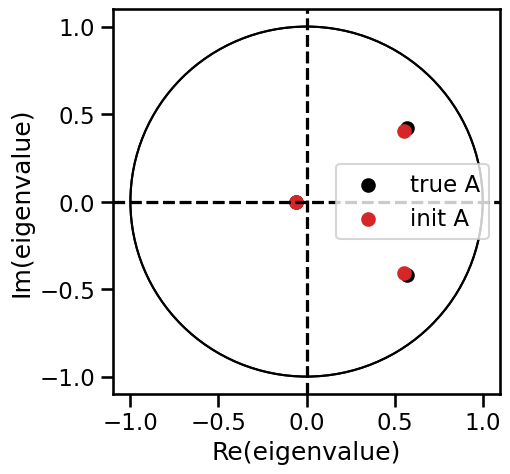

In [152]:
fig, axes = plt.subplots(figsize=(5,5))
eig = np.linalg.eigvals(trueA) 
plot_eigenvalues(axes, eig, color='black', label='true A')
initA = build_dynamics_matrix_A(initW, J)
eig = np.linalg.eigvals(initA) 
plot_eigenvalues(axes, eig, color='tab:red', label='init A')
axes.legend()
plt.show()

In [153]:
# # np.savez(f'N={N}_K={K}_true_parameters', J=J, trueA=trueA, true_b=true_b, true_s=true_s, true_mu0=true_mu0, true_Q0=true_Q0, true_C_=true_C_, true_d=true_d, true_R=true_R)
# a = np.load(f'N={N}_K={K}_true_parameters.npz')
# print(a['J'].shape)

In [154]:
ecll = data['ecll']
ll = data['ll']
lossW = data['lossW']
loss_W = data['loss_W']
fitW = data['fitW']
b = data['b']
s = data['s']
mu0 = data['mu0']
Q0 = data['Q0']
C_ = data['C_']
d = data['d']
R = data['R']
true_b = data['true_b']
true_s = data['true_s']
true_mu0 = data['true_mu0']
true_Q0 = data['true_Q0']
true_C_ = data['true_C_']
true_d = data['true_d']
true_R = data['true_R']
true_x = data['true_x']
true_y = data['true_y']


In [155]:
# # save fitted parameters
# np.savez(f'N={N}_K={K}_fitting_EM', lossW=lossW, w=w, b=b, s=s, mu0=mu0, Q0=Q0, C_=C_, d=d, R=R)
# a = np.load(f'N={N}_K={K}_initialization_weights.npz')
# print(a['initW0'].shape)

In [156]:
# # fit starting from true parameters 
# init_w = RNN.get_nonzero_weight_vector(initW)
# max_iter=25
# ecll, ll, lossW, w, b, s, mu0, Q0, C_, d, R, C_all, d_all, R_all = RNN.fit_EM(true_y, init_w, true_b.item(), true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=10, beta=10, max_iter=max_iter)

(-0.001, 0.1)

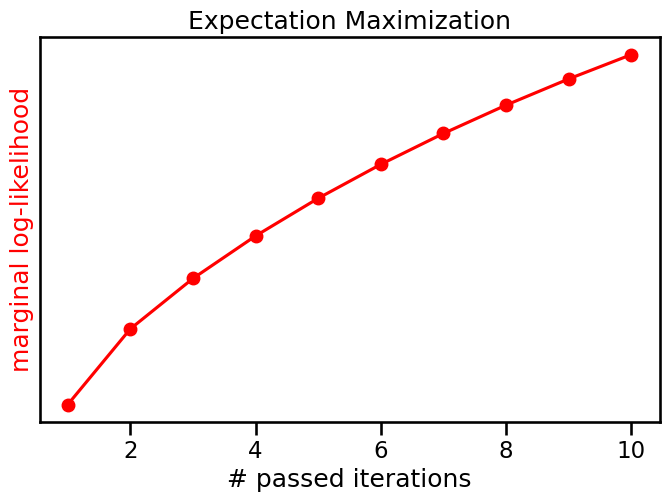

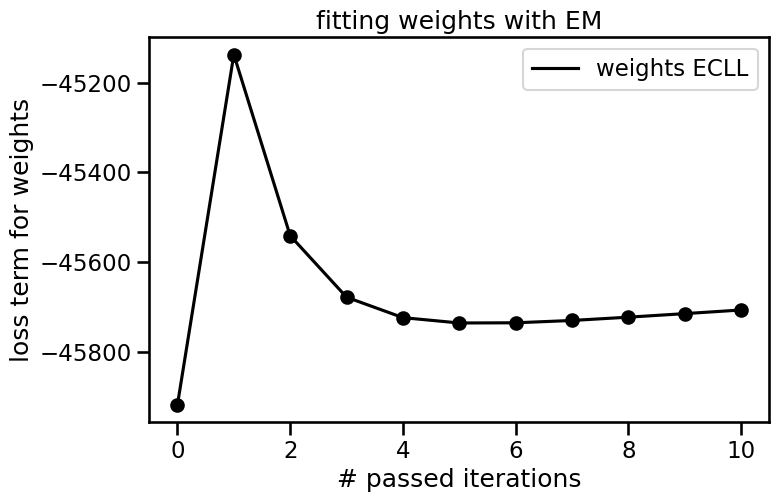

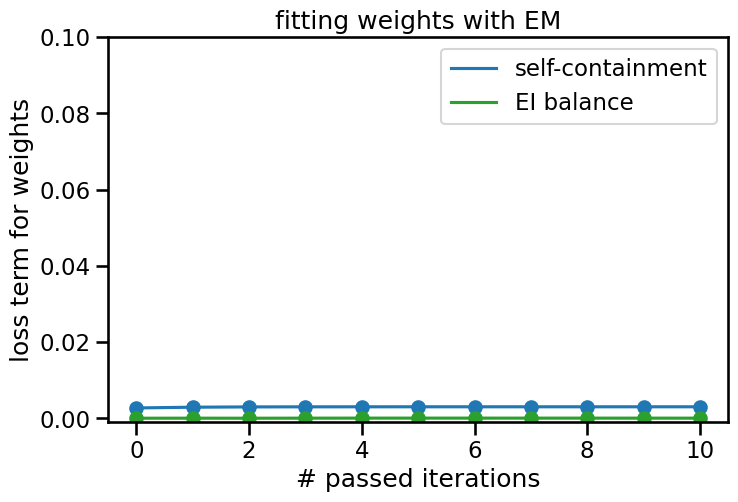

In [157]:
# iteration 0 = initialization, iteration 1 = param after one iteration
fig, axes = plt.subplots(figsize=(8,5))
# ax2 = axes.twinx()
axes.plot(range(1,max_iter+1), (ll.sum(axis=1)/(U*T))[1:], '-o', color='red')
axes.tick_params(axis='y', labelcolor='red')
axes.set_ylabel('marginal log-likelihood', color='red')
# ax2.plot(range(1,max_iter+1), ecll[1:], color='black', linestyle='dashed')
# ax2.tick_params(axis='y', labelcolor='black')
# ax2.set_ylabel('ECLL E-step')
axes.set_yticks([],[])
axes.set_title('Expectation Maximization')
axes.set_xlabel('# passed iterations')

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(max_iter+1), lossW[:,0], color='black', label='weights ECLL')
axes.scatter(range(max_iter+1), lossW[:,0], color='black')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('# passed iterations')

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(max_iter+1), lossW[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(max_iter+1), lossW[:,1], color='tab:blue')
axes.plot(range(max_iter+1), lossW[:,2], color='tab:green', label='EI balance')
axes.scatter(range(max_iter+1), lossW[:,2], color='tab:green')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('# passed iterations')
axes.set_ylim(-0.001,0.1)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


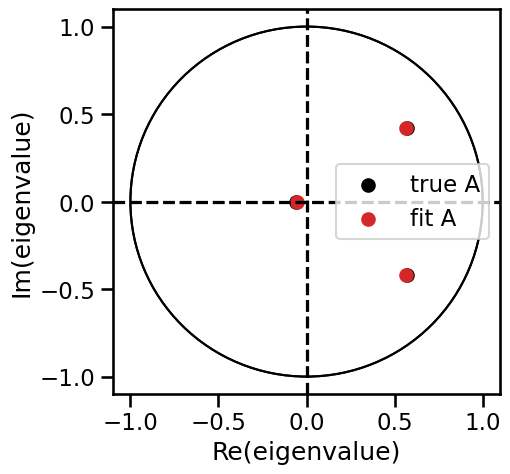

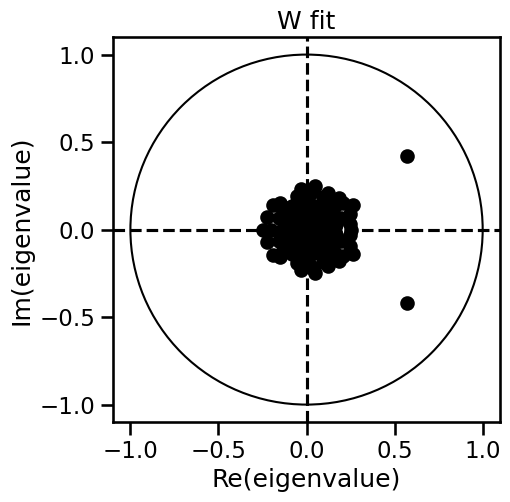

In [158]:
# recovered eigenspectrum from weights
fig, axes = plt.subplots(figsize=(5,5))
fitA = build_dynamics_matrix_A(fitW, J)
plot_eigenvalues(axes, np.linalg.eigvals(trueA), color='black', label='true A')
plot_eigenvalues(axes, np.linalg.eigvals(fitA), color='tab:red', label='fit A')
axes.legend()
plt.show()

eig = np.linalg.eigvals(fitW) 
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('W fit')
plot_eigenvalues(axes, eig)

Text(0.5, 1.0, 'Fitting other parameters with EM')

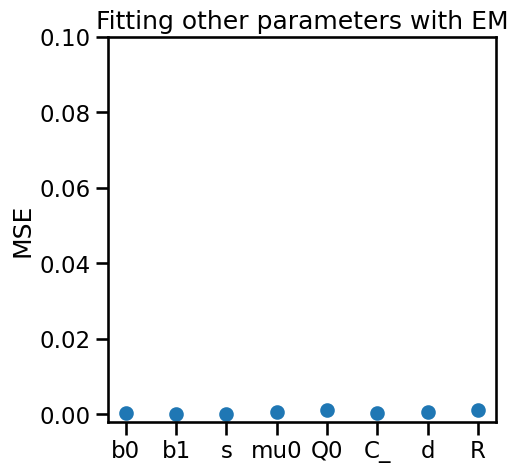

In [159]:
fig, axes = plt.subplots(figsize=(5,5))
plot_mse_parameters(axes, b.item(), 0, mu0, Q0, C_, d, R, true_b.item(), 0, true_mu0, true_Q0, true_C_, true_d, true_R)
axes.set_ylim(-0.002,0.1)
axes.set_ylabel('MSE')
axes.set_title('Fitting other parameters with EM')

In [160]:
# # compute loss and ecll and ll after last iteration

# w = RNN.get_nonzero_weight_vector(fitW)
# m = np.zeros((U, T, RNN.K, 1))
# cov = np.zeros((U, T, RNN.K, RNN.K))
# cov_next = np.zeros((U, T-1, RNN.K, RNN.K))

# ll1 = np.zeros((U))
# for u in range(U): # iterate across all trials
#     # E-step
#     mu, mu_prior, V, V_prior, ll1[u] = RNN.Kalman_filter_E_step(true_y[u], w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, R)
#     m[u], cov[u], cov_next[u] = RNN.Kalman_smoother_E_step(fitA, mu, mu_prior, V, V_prior)
# ecll1, _ = RNN.compute_ELBO(true_y, w, b, s, mu0, Q0, C_, d, R, m, cov, cov_next)

# print(ll1)
# print(ecll1)

# ll2 = np.zeros((U))
# for u in range(U): # iterate across all trials
#     # E-step
#     mu, mu_prior, V, V_prior, ll1[u] = RNN.Kalman_filter_E_step(true_y[u], w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R)
#     m[u], cov[u], cov_next[u] = RNN.Kalman_smoother_E_step(fitA, mu, mu_prior, V, V_prior)
# ecll2, _ = RNN.compute_ELBO(true_y, w, b, s, mu0, Q0, C_, d, R, m, cov, cov_next)

# print(ll2)
# print(ecll2)
           

In [161]:
# generate network activity from fit W
v = data['v']

unstable, n_unstable = check_unstable(fitW)

if unstable == False: # stable 
    v = RNN.generate_network_activity(U, T, fitW, b.item(), s, mu0, Q0)
        # print('generated network activity')
else:
    v = np.zeros((1))


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [162]:
# v_dca = v.mean(axis=0).reshape((T,N))
v_dca = v.reshape(v.shape[0] * v.shape[1], v.shape[2])

max_dim = K
ds = np.arange(1, max_dim+1)
pi = np.zeros(ds.size)
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=5, d=max_dim)
dca_model.estimate_data_statistics(v_dca) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

# for ii, d in enumerate(ds):
#     print(d)
V_opt, final_pi = dca_model._fit_projection(d=max_dim)
# pi = dca_model.score()
# Xd = dca_model.transform(v_avg)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_37608/4182024727.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_37608/4182024727.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


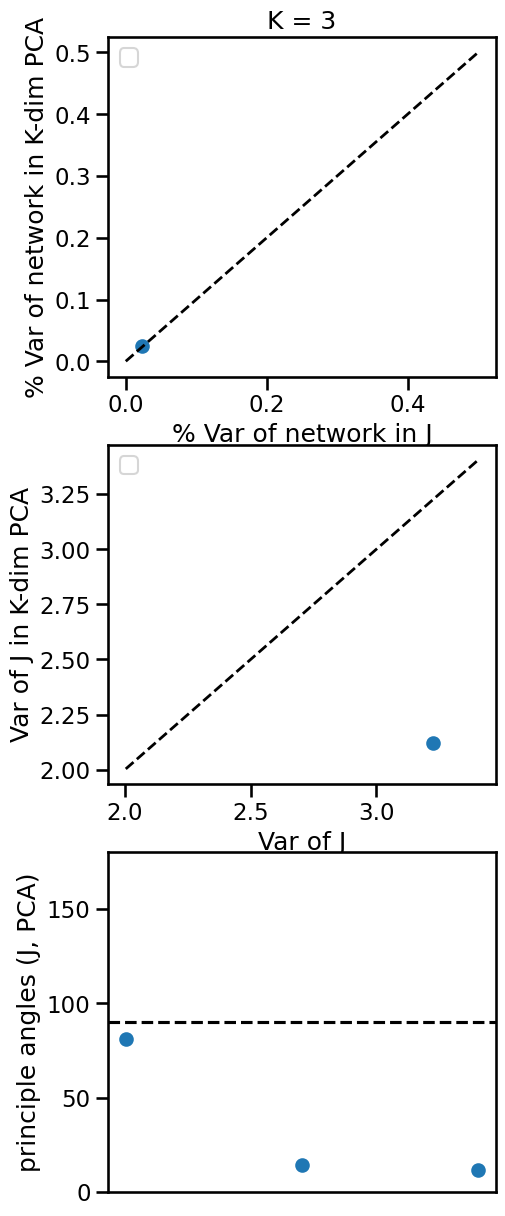

In [163]:
fig, axes = plt.subplots(3, figsize=(5,5 * 3))
fraction_cov_var_J, fraction_cov_var_DCA, cov_var_J_DCA = covariance_alignment(v_avg, J, V_opt)
axes[0].scatter(fraction_cov_var_J, fraction_cov_var_DCA)
axes[1].scatter(np.trace(J.T @ J), cov_var_J_DCA)
axes[2].scatter(range(K), np.rad2deg(scipy.linalg.subspace_angles(J.T, V_opt)))
axes[0].set_xlabel('% Var of network in J')
axes[0].set_ylabel('% Var of network in K-dim PCA')
axes[0].set_title(f'K = {K}')
axes[0].legend()
axes[1].legend()
axes[1].set_xlabel('Var of J')
axes[1].set_ylabel('Var of J in K-dim PCA')
axes[2].set_ylim(0,180)
axes[2].set_xticks([],[])
axes[2].axhline(90, linestyle='dashed',color='black')
axes[2].set_ylabel('principle angles (J, PCA)')
x = np.linspace(0, 0.5, 100)
y = x  # Diagonal y = x

# Plot with dashed linestyle
axes[0].plot(x, y, linestyle='--', color='black', linewidth=2)
# Get current axis limits
x_min, x_max = axes[1].get_xlim()
y_min, y_max = axes[1].get_ylim()

# Ensure the line spans the plot fully
start = min(x_min, y_min)
end = max(x_max, y_max)

# Plot the diagonal line
axes[1].plot([start, end], [start, end], linestyle='--', color='black', linewidth=2)



In [164]:
print(V_opt.shape)
for i in range(K):
    V_opt[:,i] = V_opt[:,i] / np.linalg.norm(V_opt[:,i])
    J[:, i] = J[:, i] /  np.linalg.norm(J[:,i])
print(np.linalg.norm(J-V_opt.T)/N)

(200, 3)
0.015185715768490829


Text(0.5, 1.0, 'projected network activity on DCA')

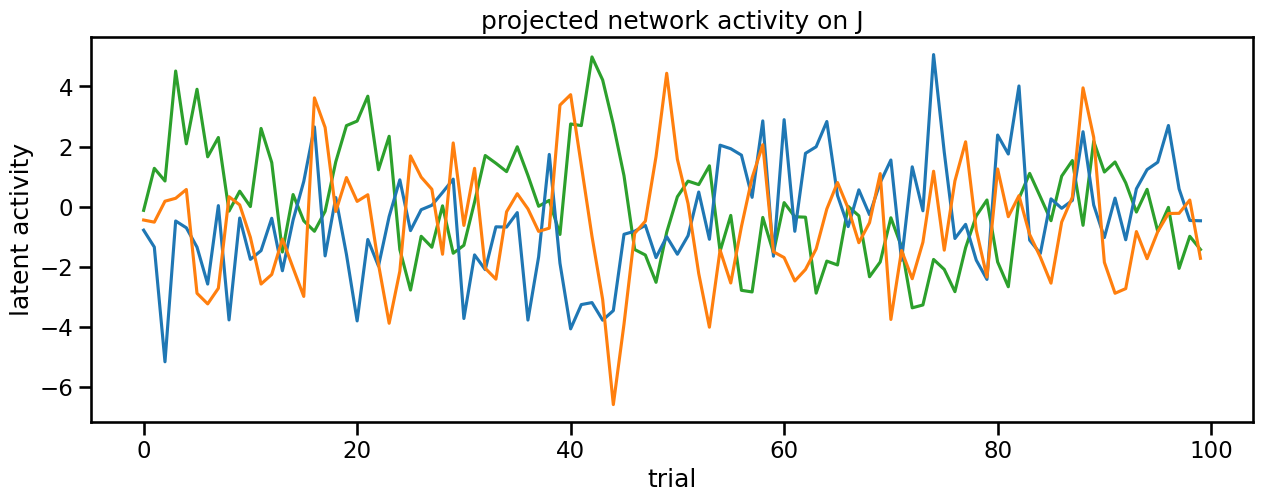

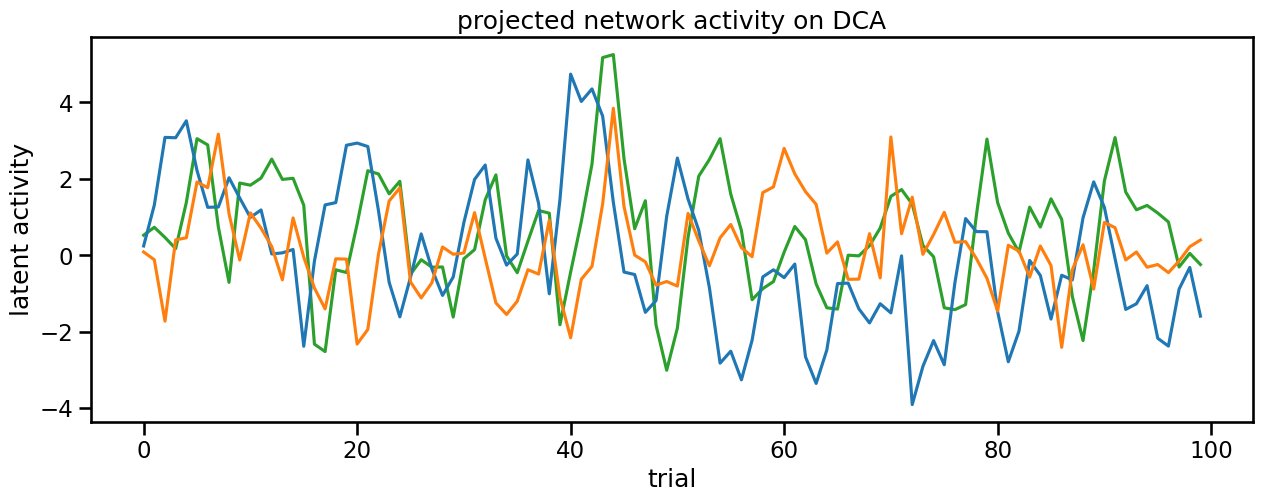

In [170]:
x, y = RNN.generate_latents_and_observations(U, T, trueA, true_b.item(), true_s, true_mu0, true_Q0, true_C_, true_d, true_R)

# fig, axes = plt.subplots(figsize=(12,5))
# for i in range(K):
#     axes.plot(x[0,:,i])
# axes.set_xlabel('trial')
# axes.set_ylabel('latent activity')
# axes.set_xlim(20,70)

fig, axes = plt.subplots(figsize=(15,5))
J = J[[1,0,2],:]
for i in range(K-1,-1,-1):
    axes.plot((J @ v[0])[:,i], color=colors_K[i])
axes.set_xlabel('trial')
axes.set_ylabel('latent activity')
axes.set_title('projected network activity on J')
# axes.set_xlim(30,70)

fig, axes = plt.subplots(figsize=(15,5))
V_opt = V_opt[:,[1,0,2]]
for i in range(K-1,-1,-1):
    axes.plot((V_opt.T @ v[0])[:,i], color=colors_K[i])
axes.set_xlabel('trial')
axes.set_ylabel('latent activity')
axes.set_title('projected network activity on DCA')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'example trial')

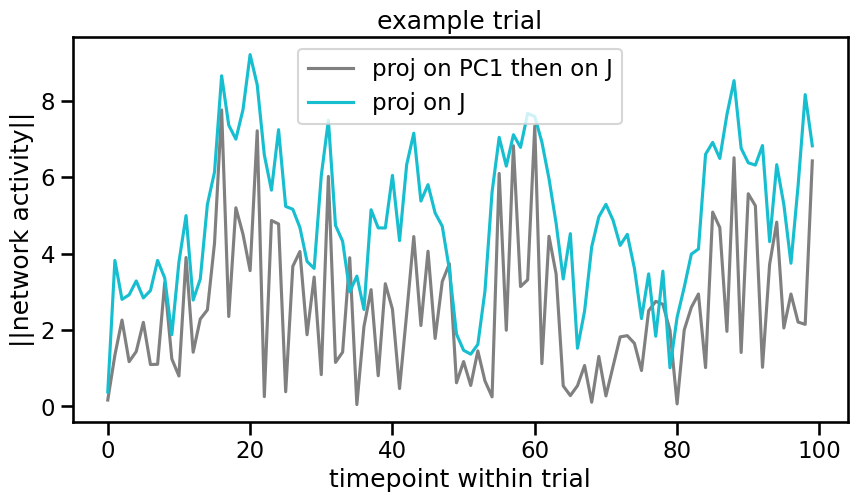

In [24]:
# session 0, trial 0

eig, eigvec = np.linalg.eig(fitA)
idx = np.argsort(eig)[::-1]
eigvec = eigvec[idx]
eigvec = eigvec[:,idx]

v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
mean = v_concat.mean(axis=0)
v_concat = v_concat - mean
eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat)

# v_proj_J_proj_eigvecA = np.zeros((T, K))
# v_proj_PCA_proj_J = np.zeros((T, K))

v_proj_J = np.zeros((T))
v_proj_PCA_proj_J = np.zeros((T))
v_proj_PCA_proj_J2 = np.zeros((T))
for t in range(T):

    v_proj_J[t] = np.linalg.norm(J @ v[25,t])
    v_proj_PCA, _ = projection_on_vector(v[25,t], eigvec_PCA[:,0])
    v_proj_PCA2, _ = projection_on_vector(v[25,t], eigvec_PCA[:,1])
    v_proj_PCA_proj_J[t] = np.linalg.norm(J @ v_proj_PCA) 
    v_proj_PCA_proj_J2[t] = np.linalg.norm(J @ v_proj_PCA2) 
    # _, v_proj_J_proj_eigvecA[t] = projection_on_vector(v_proj_J, eigvec[:,0])

fig, axes = plt.subplots(figsize=(10,5))
for k in range(1):
    axes.plot(v_proj_PCA_proj_J[:], color='gray', label='proj on PC1 then on J')
    # axes.plot(v_proj_PCA_proj_J2[:], color='gray', label='proj on PC2 then on J')
    axes.plot(v_proj_J[:], color=color_dict.get(K), label='proj on J')

axes.set_ylabel('||network activity||')
axes.set_xlabel('timepoint within trial')
axes.legend()
axes.set_title('example trial')
    
# fig, axes = plt.subplots(figsize=(10,4))
# for k in range(K):
#     axes.plot(v_proj_PCA_proj_J[:,k], color='black')
#     axes.plot(v_proj_J_proj_eigvecA[:,k], color=colormap[k])

Text(0.5, 1.0, 'projected network activity on J')

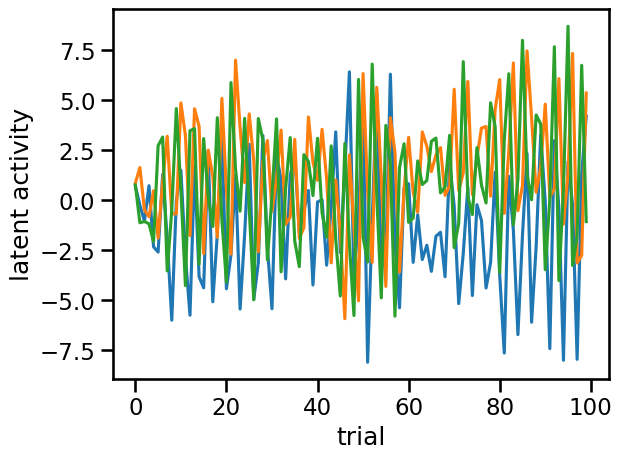

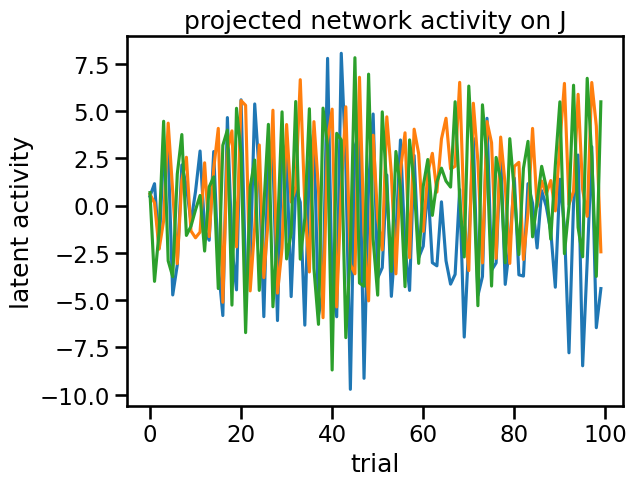

In [50]:
x, y = RNN.generate_latents_and_observations(U, T, trueA, true_b.item(), true_s, true_mu0, true_Q0, true_C_, true_d, true_R)

fig, axes = plt.subplots()
for i in range(K):
    axes.plot(x[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('latent activity')

fig, axes = plt.subplots()
for i in range(K):
    axes.plot((J @ v[0])[:,i])
axes.set_xlabel('trial')
axes.set_ylabel('latent activity')
axes.set_title('projected network activity on J')

Text(0, 0.5, 'neural activity')

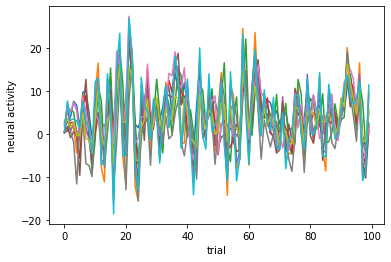

In [141]:
fig, axes = plt.subplots()
for i in range(10):
    axes.plot(y[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('neural activity')

(0.0, 0.5)

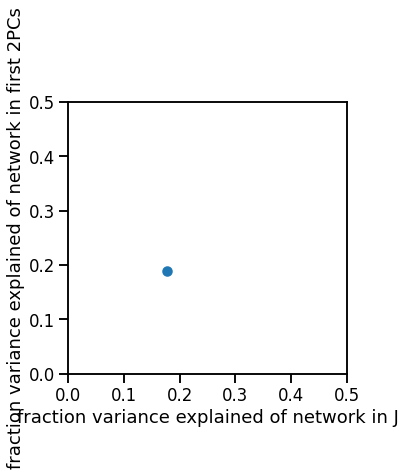

In [26]:
# alignment of two subspaces - variance explained in projection (for stable weights)

 
# PCA on data
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]

dim_PCA = K
fraction_cov_var_J, fraction_cov_var_PCA,_ = covariance_alignment(v_concat, J, eigvec_PCA[:,:dim_PCA])

fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(fraction_cov_var_J,fraction_cov_var_PCA)
axes.set_xlabel('fraction variance explained of network in J')
axes.set_ylabel('fraction variance explained of network in first 2PCs')
axes.set_xlim(0,0.5)
axes.set_ylim(0,0.5)


In [181]:
# # PCA on data
# v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
# y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# # v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# # mean = v_avg.mean(axis=0)
# mean = y_concat.mean(axis=0)

# # mean-center
# y_concat = y_concat - mean
# # v_mean = v_avg - mean

# eigval_PCA, eigvec_PCA = np.linalg.eig(y_concat.T @ y_concat) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((y_concat.shape[1]))
# # eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# # ones = np.ones((v_mean.shape[1]))
# idx = np.argsort(eigval_PCA)[::-1]
# eigval_PCA = eigval_PCA[idx]
# eigvec_PCA = eigvec_PCA[:,idx]

# # variance explained in PCA
# fig, axes = plt.subplots(figsize=(7,5))
# var_explained_pc = np.zeros((y_concat.shape[1]))
# cumul_var_explained_pc = np.zeros((y_concat.shape[1]))
# axes2 = axes.twinx()
# for i in range(var_explained_pc.shape[0]):
#     var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
#     cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
# axes.plot(range(10), var_explained_pc[:10], color='black')
# axes.scatter(range(10), var_explained_pc[:10], label='individual', color='black')
# axes2.plot(range(10), cumul_var_explained_pc[:10], color='gray')
# axes2.scatter(range(10), cumul_var_explained_pc[:10], label='cumulative', color='gray')
# axes.axhline(0, color='black', linestyle='dashed')
# axes.set_ylabel('variance explained')
# axes2.set_ylabel('cumulative variance explained')
# axes.set_xlabel('PC dimension')
# axes.set_xticks(range(10),range(1,11))
# axes2.set_ylim(0,1.05)
# axes.set_title('PCA on data')

In [182]:
# # PCA on data
# x_concat = x.reshape(x.shape[0] * x.shape[1], x.shape[2])
# # v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# # mean = v_avg.mean(axis=0)
# mean = x_concat.mean(axis=0)

# # mean-center
# x_concat = x_concat - mean
# # v_mean = v_avg - mean

# eigval_PCA, eigvec_PCA = np.linalg.eig(x_concat.T @ x_concat) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((x_concat.shape[1]))
# # eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# # ones = np.ones((v_mean.shape[1]))
# idx = np.argsort(eigval_PCA)[::-1]
# eigval_PCA = eigval_PCA[idx]
# eigvec_PCA = eigvec_PCA[:,idx]

# # variance explained in PCA
# fig, axes = plt.subplots(figsize=(7,5))
# var_explained_pc = np.zeros((x_concat.shape[1]))
# cumul_var_explained_pc = np.zeros((x_concat.shape[1]))
# axes2 = axes.twinx()
# for i in range(var_explained_pc.shape[0]):
#     var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
#     cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
# axes.plot(range(2), var_explained_pc[:], color='black')
# axes.scatter(range(2), var_explained_pc[:], label='individual', color='black')
# axes2.plot(range(2), cumul_var_explained_pc[:], color='gray')
# axes2.scatter(range(2), cumul_var_explained_pc[:], label='cumulative', color='gray')
# axes.axhline(0, color='black', linestyle='dashed')
# axes.set_ylabel('variance explained')
# axes2.set_ylabel('cumulative variance explained')
# axes.set_xlabel('PC dimension')
# axes.set_xticks(range(3),range(1,4))
# axes2.set_ylim(0,1.05)
# axes.set_title('PCA on latents')

In [183]:
# PCA on network activity
v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
y_concat = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
# v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
# mean = v_avg.mean(axis=0)
mean = v_concat.mean(axis=0)

# mean-center
v_concat = v_concat - mean
# v_mean = v_avg - mean

eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
ones = np.ones((v_concat.shape[1]))
idx = np.argsort(eigval_PCA)[::-1]
eigval_PCA = eigval_PCA[idx]
eigvec_PCA = eigvec_PCA[:,idx]
# eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
# ones = np.ones((v_mean.shape[1]))

# variance explained in PCA
fig, axes = plt.subplots(figsize=(7,5))
var_explained_pc = np.zeros((v_concat.shape[1]))
cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
axes2 = axes.twinx()
for i in range(var_explained_pc.shape[0]):
    var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
    cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
axes.plot(range(25), var_explained_pc[:25], color='black')
axes.scatter(range(25), var_explained_pc[:25], label='individual', color='black')
axes2.plot(range(25), cumul_var_explained_pc[:25], color='gray')
axes2.scatter(range(25), cumul_var_explained_pc[:25], label='cumulative', color='gray')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_ylabel('variance explained')
axes2.set_ylabel('cumulative variance explained')
axes.set_xlabel('PC dimension')
axes.set_xticks([0,1,2,3,4,5,9,14,19,24],[1,2,3,4,5,6,10,15,20,25])
axes2.set_ylim(0,1)
axes.set_title('PCA on network activity')


NameError: name 'y' is not defined

In [35]:
# project network activity on J space and do PCA

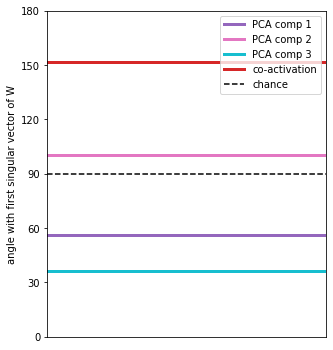

In [151]:
# SVD of fitted weight matrix - find dimension with high variance

U, s, Vh = np.linalg.svd(W)

fig, axes = plt.subplots(figsize=(5,6))
for k in range(3):
    axes.axhline(angle_vectors(U[:,0], eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)
axes.axhline(angle_vectors(U[:,0], ones), color='tab:red', label=f'co-activation', linewidth=3)
axes.axhline(90, color='black', linestyle='dashed', label='chance')
eps = 0.01
axes.set_xlim(0-eps, np.pi + eps)
axes.set_ylabel('angle with first singular vector of W')
axes.set_ylim(0,180)
axes.set_xlim(-1,1)
axes.set_xticks([],[])
axes.set_yticks([0,30,60,90,120,150,180],[0,30,60,90,120,150,180])
axes.legend()
plt.show()

In [37]:
pc1_proj_on_u1 = projection_on_vector(eigvec_PCA[:,0], U[:,0])

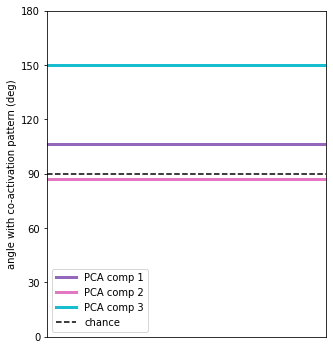

In [152]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(3):
    axes.axhline(angle_vectors(ones, eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)
axes.axhline(90, color='black', linestyle='dashed', label='chance')
eps = 0.01
axes.set_xlim(0-eps, np.pi + eps)
axes.set_ylabel('angle with co-activation pattern (deg)')
axes.set_ylim(0,180)
axes.set_xlim(-1,1)
axes.set_xticks([],[])
axes.set_yticks([0,30,60,90,120,150,180],[0,30,60,90,120,150,180])
axes.legend()
plt.show()

In [153]:
ones = np.ones((v_concat.shape[1]))
v_proj, angle = projection_on_subspace(ones,J)
print(angle)

79.32222720872204


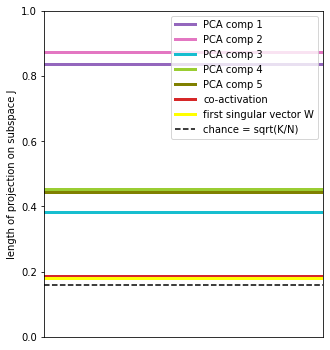

In [154]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
    axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

v_proj, angle = projection_on_subspace(ones, J)
axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)

v_proj, angle = projection_on_subspace(U[:,0],J)
axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color='yellow', label=f'first singular vector W', linewidth=3)


axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
axes.set_ylabel('length of projection on subspace J')
# axes.set_ylim(0,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()

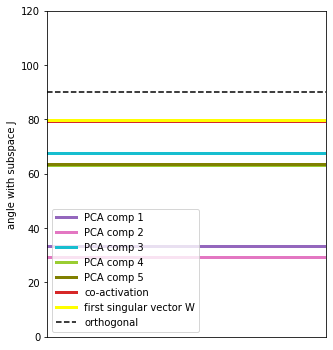

In [155]:
fig, axes = plt.subplots(figsize=(5,6))
for k in range(K):
    v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
    axes.axhline(angle, color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

v_proj, angle = projection_on_subspace(ones,J)
axes.axhline(angle, color='tab:red', label=f'co-activation', linewidth=3)

v_proj, angle = projection_on_subspace(U[:,0],J)
axes.axhline(angle, color='yellow', label=f'first singular vector W', linewidth=3)

axes.axhline(90, color='black', linestyle='dashed', label='orthogonal')
axes.set_ylabel('angle with subspace J')
axes.set_ylim(0,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()

[[ 0.        -0.70710678j  0.        +0.70710678j]
 [-0.70710678+0.j         -0.70710678-0.j        ]]


IndexError: index 2 is out of bounds for axis 1 with size 2

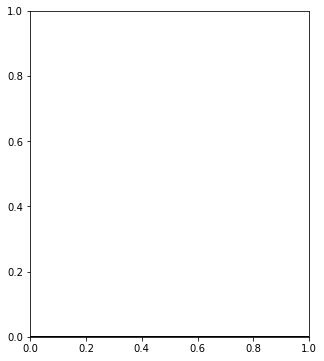

In [42]:
fig, axes = plt.subplots(figsize=(5,6))

def a(v1, v2):
    """Calculates the angle between two complex vectors."""
    return np.angle(np.dot(np.conj(v1), v2))

# eigvec_PCA_orthogonal_J = np.copy(eigvec_PCA)
# for k in range(K):
#     eigvec_PCA_orthogonal_J[k] = eigvec_PCA[:,k] @ (np.eye(N) - np.linalg.pinv(J) @ J)

eigval, eigvec = np.linalg.eig(trueA)
print(eigvec)

axes.axhline(a(eigvec[:,0], eigvec[:,1]), color='black', linewidth=3)
axes.axhline(a(eigvec[:,0], eigvec[:,2]), color='black', linewidth=3)
axes.axhline(a(eigvec[:,1], eigvec[:,2]), color='black', linewidth=3)

axes.axhline(90, color='black', linestyle='dashed', label='orthogonal')
axes.set_ylabel('angles between eigenvectors of A')
axes.set_ylim(-5,120)
axes.set_xticks([],[])
# axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
axes.legend()